In [62]:
from typing import Annotated
from typing_extensions import TypedDict 
from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import add_messages 
import getpass
import os

In [2]:
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter TAVILY_API_KEY?")

In [63]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a node in langGraph?")

[{'title': 'LangGraph - LangChain Blog',
  'url': 'https://blog.langchain.dev/langgraph/',
  'content': 'TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. graph.add_edge("tools", "model") The state of this graph by default contains concepts that should be familiar to you if you\'ve used LangChain agents: input, chat_history, intermediate_steps (and agent_outcome to represent the most recent agent outcome)',
  'score': 0.7491794},
 {'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
  'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  '

In [64]:
import getpass
import os
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq api key here")

In [66]:
from langchain_groq import ChatGroq

GROQ_LLM = ChatGroq(model="llama3-70b-8192",
    temperature=0.4,
    max_tokens=None,
    timeout=None,
    max_retries=2)

In [67]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate 
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

In [68]:

def write_markdown_file(content, filename):
  """Writes the given content as a markdown file to the local directory.

  Args:
    content: The string content to write to the file.
    filename: The filename to save the file as.
  """
  with open(f"{filename}.md", "w") as f:
    f.write(content)


## Basic Chains
1. Categorize Email 
2. Research Router 
3. Search Keywords 
4. Write Draft Email
5. Rewrite Router
6. Draft Email Analysis
7. Rewrite Email

### 1. Categorize Email 

In [69]:
from traceback import format_exc
def categorize_email(state):

    try:
        print("---CATEGORIZING INITIAL EMAIL---")
        initial_email = state['initial_email']
        num_steps = int(state['num_steps'])
        num_steps += 1

        prompt = """
            You are a Email Categorizer Agent You are a master at understanding what a customer wants when they write an email and are able to categorize it in a useful way
                Conduct a comprehensive analysis of the email provided and categorize into one of the following categories:
                    price_equiry - used when someone is asking for information about pricing \
                    customer_complaint - used when someone is complaining about something \
                    product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \\
                    customer_feedback - used when someone is giving feedback about a product \
                    off_topic when it doesnt relate to any other category \


                        Output a single cetgory only from the types ('price_equiry', 'customer_complaint', 'product_enquiry', 'customer_feedback', 'off_topic') \
                        eg:
                        'price_enquiry' \

                EMAIL CONTENT:\n\n {initial_email} \n\n
                """
        prmpt_template = PromptTemplate(
            template = prompt,
            input_variables=["initial_email"]
        )
        email_category_generator = prmpt_template | GROQ_LLM | StrOutputParser()
        result = email_category_generator.invoke({"initial_email": initial_email})
        write_markdown_file(result, "email_category")

        return {"email_category": result, "num_steps":num_steps} 
    
    except Exception as e:
        print(f"Error : {format_exc()}")
        return {"email_category": '', "num_steps":num_steps} 
    
# EMAIL = """HI there, \n
# I am emailing to say that I had a wonderful stay at your resort last week. \n

# I really appreaciate what your staff did

# Thanks,
# Paul
# """
# inputs = {"initial_email": EMAIL,"research_info": None, "num_steps":0}

# category = categorize_email(inputs)
# print(category)

In [70]:
def research_router(state):

    try:
        print("---ROUTE TO RESEARCH---")
        initial_email = state["initial_email"]
        email_category = state["email_category"]
        
        prompt  = """
        You are an expert at reading the initial email and routing web search or directly to a draft email. \n

            Use the following criteria to decide how to route the email: \n\n

            If the initial email only requires a simple response
            Just choose 'draft_email'  for questions you can easily answer, prompt engineering, and adversarial attacks.
            If the email is just saying thank you etc then choose 'draft_email'

            You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use research-info.
            Give a binary choice 'research_info' or 'draft_email' based on the question. Return the a JSON with a single key 'router_decision' and
            no premable or explaination. use both the initial email and the email category to make your decision
            Email to route INITIAL_EMAIL : {initial_email} \n
            EMAIL_CATEGORY: {email_category} \n
            """ 
        research_router_prompt = PromptTemplate(template=prompt,
                imput_variables = ["initial_email, email_category"]
                )
        research_router_engine = research_router_prompt | GROQ_LLM | JsonOutputParser()
        router = research_router_engine.invoke({"initial_email": initial_email, "email_category":email_category})
        
        print(router['router_decision'])
        if router['router_decision'] == 'research_info':
            print("---ROUTE EMAIL TO RESEARCH INFO---")
            return "research_info"
        elif router['router_decision'] == 'draft_email':
            print("---ROUTE EMAIL TO DRAFT EMAIL---")
            return "draft_email"
        
    except Exception as e:
        print(f"Errror : {e}")
        return "draft_email"
    
# email_category = 'customer_feedback'
# research_response = email_researcher( EMAIL, email_category)
# print(research_response)

### 3. Search Keywords 

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

web_search_tool = TavilySearchResults(k=1)

In [72]:
def research_info_search(state):

    try:
        
        print("---RESEARCH INFO SEARCHING---")
        initial_email = state["initial_email"]
        email_category = state["email_category"]
        num_steps = state['num_steps']
        num_steps += 1

        prompt = """
        You are a master at working out the best keywords to search for in a web search to get the best info for the customer.

        given the INITIAL_EMAIL and EMAIL_CATEGORY. Work out the best keywords that will find the best
        info for helping to write the final email.

        Return a JSON with a single key 'keywords' with no more than 3 keywords and no premable or explaination.
            INITIAL_EMAIL: {initial_email} \n
            EMAIL_CATEGORY: {email_category} \n
        """ 
        search_keyword_prompt = PromptTemplate(
            template=prompt,
            input_variables=["initial_email","email_category"]
        )
        search_keyword_chain = search_keyword_prompt | GROQ_LLM | JsonOutputParser()
        response = search_keyword_chain.invoke({"initial_email": initial_email, "email_category":email_category})
        keywords = response['keywords']
        full_searches = []
        for keyword in keywords[:1]:
            print(keyword)
            temp_docs = web_search_tool.invoke({"query": keyword})
            web_results = "\n".join([d["content"] for d in temp_docs])
            web_results = Document(page_content=web_results)
        if full_searches is not None:
            full_searches.append(web_results)
        else:
            full_searches = [web_results]   
        return {"research_info": full_searches, "num_steps":num_steps}
    
    except Exception as e:
        print(f"Error : {e}")
        {"research_info": [], "num_steps":num_steps}

# email_category = 'customer_feedback'
# research_info_search(EMAIL, email_category)

In [73]:
def draft_email_writer(state):

    try:
        print("---DRAFT EMAIL WRITER---")
        ## Get the state
        initial_email = state["initial_email"]
        email_category = state["email_category"]
        research_info = state["research_info"]
        num_steps = state['num_steps']
        num_steps += 1

        prompt = """
            You are the Email Writer Agent take the INITIAL_EMAIL below  from a human that has emailed our company email address, the email_category \
                that the categorizer agent gave it and the research from the research agent and \
                write a helpful email in a thoughtful and friendly way.

                If the customer email is 'off_topic' then ask them questions to get more information.
                If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
                If the customer email is 'customer_feedback' then try to assure we value them and that we are addressing their issues.
                If the customer email is 'product_enquiry' then try to give them the info the researcher provided in a succinct and friendly way.
                If the customer email is 'price_equiry' then try to give the pricing info they requested.

                You never make up information that hasn't been provided by the research_info or in the initial_email.
                Always sign off the emails in appropriate manner and from Sarah the Resident Manager.

                Return the email a JSON with a single key 'email_draft' and no premable or explaination.
                
                INITIAL_EMAIL: {initial_email} \n
                EMAIL_CATEGORY: {email_category} \n
                RESEARCH_INFO: {research_info} \n
            """
        draft_writer_prompt = PromptTemplate(template=prompt, input_variables=["initial_email","email_category","research_info"])
        draft_writer_chain = draft_writer_prompt | GROQ_LLM | JsonOutputParser()
        draft_email = draft_writer_chain.invoke({"initial_email": initial_email, "email_category":email_category,"research_info":research_info})
        return  {"draft_email": draft_email, "num_steps":num_steps}
    except Exception as e:
        print(f"Error : {e}")
        return  {"draft_email": "", "num_steps":num_steps} 
    
# email_category = 'customer_feedback'
# research_info = None
# response = write_drift_email(EMAIL, email_category, research_info)
# print(response)

In [74]:
def route_to_rewrite(state):

    try:
        print("---ROUTE TO REWRITE---")
        initial_email = state["initial_email"]
        email_category = state["email_category"]
        draft_email = state["draft_email"]

        prompt = """
            You are an expert at evaluating the emails that are draft emails for the customer and deciding if they
        need to be rewritten to be better. \n

        Use the following criteria to decide if the DRAFT_EMAIL needs to be rewritten: \n\n

        If the INITIAL_EMAIL only requires a simple response which the DRAFT_EMAIL contains then it doesn't need to be rewritten.
        If the DRAFT_EMAIL addresses all the concerns of the INITIAL_EMAIL then it doesn't need to be rewritten.
        If the DRAFT_EMAIL is missing information that the INITIAL_EMAIL requires then it needs to be rewritten.

        Give a binary choice 'rewrite' (for needs to be rewritten) or 'no_rewrite' (for doesn't need to be rewritten) based on the DRAFT_EMAIL and the criteria.
        Return the a JSON with a single key 'router_decision' and no premable or explaination. \n

        INITIAL_EMAIL: {initial_email} \n
        EMAIL_CATEGORY: {email_category} \n
        DRAFT_EMAIL: {draft_email} \n
        """ 
        rewrite_router_prompt = PromptTemplate(template=prompt, input_variables=["initial_email","email_category","draft_email"])
        rewrite_router = rewrite_router_prompt | GROQ_LLM | JsonOutputParser()
        router = rewrite_router.invoke({"initial_email": initial_email, "email_category":email_category, "draft_email":draft_email})
        print(router)
        print(router['router_decision'])
        if router['router_decision'] == 'rewrite':
            print("---ROUTE TO ANALYSIS - REWRITE---")
            return "rewrite"
        elif router['router_decision'] == 'no_rewrite':
            print("---ROUTE EMAIL TO FINAL EMAIL---")
            return "no_rewrite"
    
    except Exception as e:
        print(f"Error : {e}")
        return None 
    
# email_category = 'customer_feedback'
# draft_email = "Yo we can't help you, best regards Sarah"
# rewrite_router(EMAIL, email_category, draft_email)


In [ ]:
def analyze_draft_email(state):
    
    print("---DRAFT EMAIL ANALYZER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    print(f"draft_email --> {draft_email}")
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1
    
    prompt = """ 
       You are the Quality Control Agent read the INITIAL_EMAIL below  from a human that has emailed \
        our company email address, the email_category that the categorizer agent gave it and the \
        research from the research agent and write an analysis of how the email.

        Check if the DRAFT_EMAIL addresses the customer's issued based on the email category and the \
        content of the initial email.\n

        Give feedback of how the email can be improved and what specific things can be added or change\
        to make the email more effective at addressing the customer's issues.

        You never make up or add information that hasn't been provided by the research_info or in the initial_email.

        Return the analysis a JSON with a single key 'draft_analysis' and no premable or explaination.    
        
        INITIAL_EMAIL: {initial_email} \n\n
        EMAIL_CATEGORY: {email_category} \n\n
        RESEARCH_INFO: {research_info} \n\n
        DRAFT_EMAIL: {draft_email} \n\n
    """
    draft_analysis_prompt = PromptTemplate(template=prompt, input_variables=["initial_email","email_category","research_info"])
    draft_analysis_chain = draft_analysis_prompt | GROQ_LLM | JsonOutputParser()
    draft_email_feedback = draft_analysis_chain.invoke({"initial_email": initial_email,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email})
    write_markdown_file(str(draft_email_feedback), "draft_email_feedback")

    return {"draft_email_feedback": draft_email_feedback, "num_steps":num_steps}

# email_anaylsis


In [109]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Paul
"""
email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

inputs = {"initial_email" : EMAIL, "email_category" :email_category, "research_info" : research_info, "draft_email" : draft_email, "num_steps" : 0}
analyze_draft_email(inputs)

---DRAFT EMAIL ANALYZER---
draft_email --> Yo we can't help you, best regards Sarah


{'draft_email_feedback': {'draft_analysis': {'addressing_customer_issue': False,
   'feedback': "The draft email does not acknowledge the customer's positive feedback and does not show appreciation for their kind words. It also has an unprofessional tone with the use of 'Yo' and a dismissive statement. To improve the email, it should start with a thank you note to the customer for taking the time to share their feedback. It could also express gratitude for their appreciation of the staff's efforts. The tone should be professional and courteous throughout the email."}},
 'num_steps': 1}

In [ ]:
def rewrite_email(state):

    try:
        print("---ReWRITE EMAIL ---")
        ## Get the state
        initial_email = state.get("initial_email")
        email_category = state.get("email_category")
        draft_email = state.get("draft_email")
        research_info = state.get("research_info")
        draft_email_feedback = state.get("draft_email_feedback")
        num_steps = state.get('num_steps')
        num_steps += 1
        prompt = """ 
          
            You are the Final Email Agent read the email analysis below from the QC Agent \
            and use it to rewrite and improve the draft_email to create a final email.


            You never make up or add information that hasn't been provided by the research_info or in the initial_email.

            Return the final email as JSON with a single key 'final_email' which is a string and no premable or explaination.  
            EMAIL_CATEGORY: {email_category} \n\n
            RESEARCH_INFO: {research_info} \n\n
            DRAFT_EMAIL: {draft_email} \n\n
            DRAFT_EMAIL_FEEDBACK: {email_analysis} \n\n 
        """
        
        rewrite_email_prompt = PromptTemplate(template=prompt, input_variables=["initial_email", "email_category", "research_info",
                     "email_analysis", "draft_email"])
        rewrite_chain = rewrite_email_prompt | GROQ_LLM | JsonOutputParser()
        final_email = rewrite_chain.invoke({"initial_email": initial_email,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email,
                                "email_analysis":draft_email_feedback})
        write_markdown_file(str(final_email), "final_email")

        return  {"final_email": final_email['final_email'], "num_steps":num_steps}
    
    except Exception as e:
        print(f"Error : {e}")
        return {"final_email": '', "num_steps":num_steps}
# email_category = 'customer_feedback'
# research_info = None
# draft_email = "Yo we can't help you, best regards Sarah"
# final_email_response = rewrite_email(EMAIL, email_category, research_info, draft_email, email_anaylsis)
# final_email_response

In [130]:
# inputs = {"initial_email": EMAIL, "email_category" : "customer_feedback", research_info: None, "num_steps":0}
# rewrite_email(inputs)

## Tool Setup

In [77]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=1)

## State

In [78]:
from langchain.schema import Document 
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict
from typing import List 

In [79]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        initial_email: email
        email_category: email category
        draft_email: LLM generation
        final_email: LLM generation
        research_info: list of documents
        info_needed: whether to add search info
        num_steps: number of steps
    """
    initial_email : str 
    email_category : str 
    draft_email : str 
    final_email : str 
    final_email : str 
    research_info : List[str]
    info_needed : bool 
    num_steps : int 
    draft_email_feedback : dict 
    

In [83]:
def state_printer(state):
    """print the state"""
    print("---STATE PRINTER---")
    print(f"Initial Email: {state.get('initial_email')} \n" )
    print(f"Email Category: {state.get('email_category')} \n")
    print(f"Draft Email: {state.get('draft_email')} \n" )
    print(f"Final Email: {state.get('final_email')} \n" )
    print(f"Research Info: {state.get('research_info')} \n")
    print(f"Info Needed: {state.get('info_needed')} \n")
    print(f"Num Steps: {state.get('num_steps')} \n")
    return 

In [86]:

EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
"""
state_printer({"initial_email": EMAIL,"research_info": None, "num_steps":0})

---STATE PRINTER---
Initial Email: HI there, 

I am emailing to say that the resort weather was way to cloudy and overcast. 

I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
 

Email Category: None 

Draft Email: None 

Final Email: None 

Research Info: None 

Info Needed: None 

Num Steps: 0 



In [89]:
def no_rewrite(state):
    print("---NO REWRITE EMAIL ---")
    ## Get the state
    draft_email = state.get("draft_email", None)
    num_steps = state.get('num_steps')
    num_steps += 1

    write_markdown_file(str(draft_email), "final_email")
    return {"final_email": draft_email, "num_steps":num_steps}

In [90]:
no_rewrite({"initial_email": EMAIL,"research_info": None, "num_steps":0})

---NO REWRITE EMAIL ---


{'final_email': None, 'num_steps': 1}

## Add Nodes

In [117]:
workflow = StateGraph(GraphState)

workflow.add_node("categorize_email", categorize_email)
workflow.add_node("research_info_search", research_info_search)
workflow.add_node("state_printer", state_printer)
workflow.add_node("draft_email_writer", draft_email_writer)

workflow.add_node("analyze_draft_email", analyze_draft_email)
workflow.add_node("rewrite_email", rewrite_email)
workflow.add_node("no_rewrite", no_rewrite)


## Add Edges

In [118]:
workflow.set_entry_point("categorize_email")
workflow.add_conditional_edges(
    "categorize_email",
    research_router,
    {
        "research_info" : "research_info_search",
        "draft_email" : "draft_email_writer"
    },
)
workflow.add_edge("research_info_search", "draft_email_writer")
workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite" : "analyze_draft_email",
        "no_rewrite" : "no_rewrite"
    },
)
workflow.add_edge("analyze_draft_email", "rewrite_email")
workflow.add_edge("no_rewrite", "state_printer")
workflow.add_edge("rewrite_email", "state_printer")
workflow.add_edge("state_printer", END)

In [119]:
app = workflow.compile()

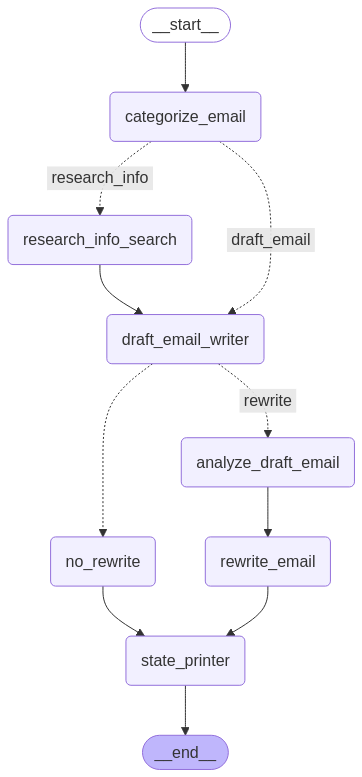

In [131]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [124]:
# EMAIL = """HI there, \n
# I am emailing to find out the current price of Bitcoin. \n

# Can you please help me/

# Thanks,
# John
# """

# EMAIL = """HI there, \n
# I am emailing to say that I had a wonderful stay at your resort last week. \n

# I really appreaciate what your staff did

# Thanks,
# Paul
# """

EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
"""

# EMAIL = """HI there, \n
# Why can't I get to sing?

# Thanks,
# Ringo
# """

# EMAIL = """HI there, \n
# Thanks for confirming my booking

# Thanks,
# Ringo
# """

In [125]:
from pprint import pprint
# run the agent
inputs = {"initial_email": EMAIL,"research_info": None, "num_steps":0}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

---CATEGORIZING INITIAL EMAIL---
---ROUTE TO RESEARCH---
research_info
---ROUTE EMAIL TO RESEARCH INFO---
'Finished running: categorize_email:'
---RESEARCH INFO SEARCHING---
resort weather complaints
'Finished running: research_info_search:'
---DRAFT EMAIL WRITER---
---ROUTE TO REWRITE---
{'router_decision': 'no_rewrite'}
no_rewrite
---ROUTE EMAIL TO FINAL EMAIL---
'Finished running: draft_email_writer:'
---NO REWRITE EMAIL ---
'Finished running: no_rewrite:'
---STATE PRINTER---
Initial Email: HI there, 

I am emailing to say that the resort weather was way to cloudy and overcast. 

I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
 

Email Category: After conducting a comprehensive analysis of the email, I would categorize it as:

'customer_complaint'

The email expresses dissatisfaction with the weather conditions during the customer's stay at the resort, and t

In [133]:
output = app.invoke(inputs)

print(output['final_email'])

---CATEGORIZING INITIAL EMAIL---
---ROUTE TO RESEARCH---
research_info
---ROUTE EMAIL TO RESEARCH INFO---
---RESEARCH INFO SEARCHING---
arizona weather april
---DRAFT EMAIL WRITER---
---ROUTE TO REWRITE---
{'router_decision': 'no_rewrite'}
no_rewrite
---ROUTE EMAIL TO FINAL EMAIL---
---NO REWRITE EMAIL ---
---STATE PRINTER---
Initial Email: HI there, 

I am emailing to say that the resort weather was way to cloudy and overcast. 

I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
 

Email Category: 'customer_complaint' 

Draft Email: {'email_draft': "Dear George,\n\nThank you for reaching out to us about your recent experience at our resort in Arizona. I'm so sorry to hear that the weather was not up to your expectations. We understand how important it is to have good weather during your vacation.\n\nI must say, I love the idea of your song 'Here comes the sun but

In [ ]:
…or create a new repository on the command line
echo "# multi_agent_email_response_generator" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/muxair080/multi_agent_email_response_generator.git
git push -u origin main